# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Table of contents

1. [Importing libaries & dataset](#data)
2. Explore and clean data :
    [portfolio](#portfolio)
    [profile](#profile)
    [transcript](#transcript)
3. [Exploratory analysis](#explore)
4. [Modeling](#model)
5. [Conclusion](#conclude)


<font color="orangered">Jump right into the <strong> 3. Exporatory Analysis</strong> part if you want to skip the data cleaning and </font>

<a id="data"></a>
# `SECTION 1`

## Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import os.path
from tqdm import tqdm # progress bar

%matplotlib inline
%config Completer.use_jedi = False # autocomplete

## Importing data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

---
# `SECTION 2` Exploring & cleaning data

There are three dataset to explore and clean.

<a id="portfolio"></a>
## `DATA 1` portfolio

In [ ]:
portfolio.info() 

#### Commentary

There are only 10 offers available in the data as it is a simplified version. 

For cleaning, note the following:
- no missing value exists
- date types look okay
- need to destructure `channels` column as it is list <font color="orangered">(to do)</font>
- just confirm if there is any duplicates <font color="orangered">(to do)</font>

After cleaning, I would like to return:
- a grouped by table that shows summary statistics of offers by `offer_type`

### Function to clean `portfolio` data

In [ ]:
def clean_portfolio(df):
    ''' Clean the 'portolio' dataset, achieving :
    1. Destructure 'channels' column
    2. Drop 'channels' column after destructing
    
    INPUT: a Pandas dataframe that contains portfolio data
    OUTPUT: a clean dataframe 
    '''
    
    # Get unique channels 
    temp_list = list()

    for _type in df.channels:
        temp_list.extend(_type)

    channel_list = set(temp_list)
    
    
    # Create binary tables for channels
    channel_bool = dict()

    for _type in channel_list:
        channel_bool[_type] = df.channels.apply(lambda x: _type in x)
    
    channel_df = pd.DataFrame(channel_bool)
    
    
    # Transform boolean to binary integer (True: 1, False: 0)
    binary_rule = {True: 1, False: 0}
    
    for col in channel_df.columns:
        channel_df[col] = channel_df[col].map(binary_rule) 
       
    # Join the binary columns to the original dataframe
    df_clean = df.join(channel_df)
    
    # Drop 'channels' columns
    df_clean = df_clean.drop(columns='channels')
    
    
    return df_clean
    

In [ ]:
# Clean portfolio dataframe
portfolio_v1 = clean_portfolio(portfolio)
portfolio_v1

In [ ]:
# Check for duplicates
assert portfolio_v1.duplicated().sum() == 0, "There is at least one duplicated offer"

In [ ]:
# Printing stats table including channels
portfolio_v1.groupby('offer_type').mean()

#### Commentary:

Customers gets the most reward from `bogo` it is less difficult to redeem than `discount` which requires more spends. 

When sending out offers, `email` is opted always. `bogo` looks the most aggressive offer utilising the 4 channels the most (just as it sounds).

In [ ]:
# Saving the cleand dataframe as 'portfolio_v1'
portfolio_v1.to_csv('data/portfolio_v1.csv', index=False)

<a id="profile"></a>
## `DATA 2` profile

In [ ]:
profile.head(3) 

In [ ]:
profile.info() 

In [ ]:
# Check for duplicates by id
assert profile.duplicated(subset='id').sum() == 0, "There is at least one duplicated record"

In [ ]:
# 2175 records with null data 
# age of 118 is odd so to remove
print(profile[profile.gender.isnull()].head(3))
profile[profile.gender.isnull()].age.value_counts() 

#### Commentary

There is no duplicated id. `profile` data contains all unique user ids.

For cleaning, note the following:
- 2175 missing value exists in `gender`, `income` columns: contain age of 118 which is abnormal <font color="orangered">(drop them) - 12.7% of the data</font>
- `become_member_on` to be converted to datetime object

### Function to clean `profile` data

In [ ]:
def clean_profile(df):
    ''' Clean the 'portolio' dataset, achieving :
    1. Drop nulls
    2. Convert 'become_member_on' to datetime object
    
    INPUT: a Pandas dataframe that contains profile data
    OUTPUT: a clean dataframe 
    '''
    
    # Copy the original dataframe
    df_clean = df.copy()
    
    # Drop nulls
    df_clean = df_clean[df_clean.gender.notnull()]
    
    # Convert to datetime object
    df_clean.loc[:, 'became_member_on'] = pd.to_datetime(df_clean.became_member_on, format="%Y%m%d")
    
    return df_clean


In [ ]:
# Check for any remaining null data 
assert profile_v1.shape[0] == profile.shape[0] - 2175, "It looks that missing values are not dropped correctly"
assert profile_v1.isnull().sum().sum() == 0, "There still is missing value"

In [ ]:
# Save the clean data as profile_v1
profile_v1.to_csv('data/profile_v1.csv', index=False)

<a id="transcript"></a>
## `DATA 3` transcript

In [ ]:
transcript.info()

In [ ]:
transcript.head()

In [ ]:
transcript.event.value_counts()

### Quick inspection of the `value` column

In [ ]:
# Destructoring dictionary in 'value' column 
temp = transcript.copy()

In [ ]:
# Extract unique keys from the dictionary
value_keys = []

for _dict in temp.value:
    for keys in _dict.keys():
        value_keys.append(keys)
        
print(set(value_keys))

#### Commentary

There are 3 unique keys in the dictionary, while `offer_id` and `offer id` should give the same information. 

- We need destructuring the dictionary first 
- Then combine `offer_id` and `offer id` column together into `offer_id` column
- drop `offer id` column

In [ ]:
# Quick way to destructure using 'json_normalize' method
value_destructured = pd.json_normalize(temp['value'])
value_destructured

In [ ]:
# Merge 'offer_id' and 'offer id' columns 
# np.where(condition, value if true, value if false)
value_destructured['offer_id'] = np.where(value_destructured['offer id'].notnull(), 
                                          value_destructured['offer id'], 
                                          value_destructured['offer_id'])

# Drop the unnecessary offer id column if merger successful
assert value_destructured['offer_id'].notnull().sum() == 167581, "It is an incorrect merge"
value_destructured = value_destructured.drop(columns='offer id')

In [ ]:
# Inspecting amount column
print('Number of transactions made: ', value_destructured.amount.notnull().sum(), end='\n\n')
print(value_destructured.amount.describe())

sns.histplot(x=value_destructured.amount, binwidth=5); # every $5
plt.title('Distribution of transaction amounts');
plt.xlim([0,100]); # removing outliers i.e. max value of $1062.28

In [ ]:
# Transation value over $100 (hidden from the graph above)
print(f'#trans over $100: {(value_destructured.amount > 100).sum()}')
print(f'  in percentage: {(value_destructured.amount > 100).sum() / 138953 * 100:.2f}%')

Most of the amounts fall below $100 with some outliers that are minor enough to be ignored. Note that transaction values here includes those purchased with no offers as well.

In [ ]:
# Inspecting reward column
print('Total number of rewards given:', len(value_destructured.reward.notnull()))

sns.countplot(x=value_destructured.reward);
plt.title('Rewards given for completing offers and their counts');

Rewards are given for offers that are completed. Therefore, it must correspond to `offer completed` events only. Reward 5 has been given the most followed by reward 2. 

#### Commentary - `transcript` data:

There are four types of event following marketing funnels. As mentioned earlier an offer can be completed without receiving / viewing offer. Also, transaction can happen with no offer redeemed.

No missing data is found in `transcript` data. However, after destructuring `value` column many null values are generated, which is to address no transactions / rewards and delivers a correct picture - no need to drop.
 
For cleaning, 
- destructor dictionary in `value` column <font color="orangered">(to do)</font>
- make the keys of the ditionary in `value` column consistent <font color="orangered">(to do)</font>
- drop the original `value` column <font color="orangered">(to do)</font>

### Function to clean `transcript` data

In [ ]:
def clean_transcript(df):
    ''' Clean the 'transcript' dataset, achieving :
    1. Destructure dictionary in 'value' column & create a new dataframe
    2. Ensure consistency by merging offer_id with offer id column
    3. Drop the duplicated offer id column
    3. Join the new dataframe to the original transcript dataframe
    4. Drop the original 'value' column

    INPUT: a Pandas dataframe that contains transcript data
    OUTPUT: a clean dataframe 
    '''
    
    # Instantiate df_clean as a copy of df
    df_clean = df.copy()
    
    # Destructoring dictionary in 'value' column 
    value_df = pd.json_normalize(df.value)
    
    # Making values in 'value_key' column consistent + testing the result
    # 'offer id' column merged 'offer_id' & test the change

    # For testing, the merged column size should match sum of count 1 & 2
    count1 = value_df['offer_id'].notnull().sum()
    count2 = value_df['offer id'].notnull().sum()
    
    value_df['offer_id'] = np.where(value_df['offer id'].notnull(), 
                                    value_df['offer id'], value_df['offer_id'])
    
    # Testing if merged successfully
    assert value_df['offer_id'].notnull().sum() == count1 + count2
    
    # Drop offer id column
    value_df = value_df.drop(columns='offer id')

    df_clean = df_clean.join(value_df)
    
    # Drop the original 'value' column
    df_clean = df_clean.drop(columns='value')
    
    
    return df_clean
    

In [ ]:
# Returning the clean dataframe
transcript_v1 = clean_transcript(transcript)
transcript_v1

### Post cleaning inspection for `transcript_v1`

In [ ]:
# If there is a value in 'amount', it should be about transaction
assert transcript_v1[transcript_v1.amount.notnull()].event.unique()[0] == 'transaction'

In [ ]:
# Check for duplicates by 'person' and 'value_key'
transript_v1_duplicated = transcript_v1[transcript_v1.duplicated(keep=False)]
transript_v1_duplicated

In [ ]:
# Duplicated event 
transript_v1_duplicated.event.hist();

In [ ]:
# Inspection for duplicates with a sample 
sample = transcript_v1[transcript_v1.person == 'b7e216b6472b46648272c29a52a86702']
sample

#### Commentary
About 397 fields (793 rows / 2) have duplicated records and it happends for `offer completed` event only. 

The above sample data shows the same type of duplication (idx# 305550, 305551). The duplicated fields do not really convery any meaningful data so drop duplicates (keep first).

### Drop duplicates in `transcript_v1`

In [ ]:
print(f'Before dropping duplicates: {transcript_v1.shape[0]} records')
print(f'Total {transcript_v1.duplicated().sum()} duplicates exist')

In [ ]:
transcript_v1 = transcript_v1.drop_duplicates(keep='first')

In [ ]:
# Confirm the changes
assert transcript_v1.shape[0] == 306534 - 397, "There is something wrong"

In [ ]:
# Save the clean data as transcript_v1
transcript_v1.to_csv('data/transcript_v1.csv', index=False)

### `transcript_v1` - further cleaning needed!
Before any explatory analysis, we need a further cleaning of `transcript_v1` dataframe in order to clearly identify how funnels work and customers react to offers.

As instructed in the introdution, transactions can be made without customers actually viewing offers, which does not really tell that customers were influenced by the offers.

Therefore, we need to work on:
1. Make `event` column categorical ordered
2. Fill NaN value in `offer_id` for `transaction` made as a result of offer completion
3. Pivot `transcript_v1` to see which offer / person completed offer or not

The explanation here may not sound clear. So, I will explain the work along the way.

In [51]:
transcript_v1 = pd.read_csv('data/transcript_v1.csv')

#### Re-order event
It is understood that when an offer is completed, it follows funnles like below:  
    
    'offer received' -> 'offer viewed' ->'transaction' -> 'offer completed'
    
For later use, it is reasonable to make the `event` column categorical (ordered).

In [52]:
# Transform event column into categorical ordered dtype
funnel_order = ['offer received', 'offer viewed', 'transaction', 'offer completed']
transcript_v1.event = pd.Categorical(transcript_v1.event, categories=funnel_order, ordered=True)

In [53]:
# Sorting the dataframe by person, offer_id and then event
# will represent dataframe in order of event(funnel) for each offer
transcript_sorted = transcript_v1.sort_values(by=['person', 'offer_id', 'time'])
transcript_sorted

,person,event,time,amount,offer_id,reward
247632,0009655768c64bdeb2e877511632db8f,offer received,576,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
258632,0009655768c64bdeb2e877511632db8f,offer completed,576,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
113591,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN
139973,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,NaN
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
...,...,...,...,...,...,...
200113,ffff82501cea40309d5fdd7edcca4a07,transaction,498,13.17,NaN,NaN
214570,ffff82501cea40309d5fdd7edcca4a07,transaction,504,7.79,NaN,NaN
258113,ffff82501cea40309d5fdd7edcca4a07,transaction,576,14.23,NaN,NaN
274495,ffff82501cea40309d5fdd7edcca4a07,transaction,606,10.12,NaN,NaN


In [54]:
# Let's inspect in more detail with a sample
sample = transcript_sorted[transcript_sorted.person == 'ffff82501cea40309d5fdd7edcca4a07']

In [55]:
sample

,person,event,time,amount,offer_id,reward
54574,ffff82501cea40309d5fdd7edcca4a07,offer received,168,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
69621,ffff82501cea40309d5fdd7edcca4a07,offer viewed,174,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
79661,ffff82501cea40309d5fdd7edcca4a07,offer completed,198,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0
112200,ffff82501cea40309d5fdd7edcca4a07,offer received,336,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
133059,ffff82501cea40309d5fdd7edcca4a07,offer viewed,354,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
143768,ffff82501cea40309d5fdd7edcca4a07,offer completed,384,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
152007,ffff82501cea40309d5fdd7edcca4a07,offer received,408,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
167990,ffff82501cea40309d5fdd7edcca4a07,offer viewed,414,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
167992,ffff82501cea40309d5fdd7edcca4a07,offer completed,414,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
246248,ffff82501cea40309d5fdd7edcca4a07,offer received,576,NaN,2906b810c7d4411798c6938adc9daaa5,NaN


#### Commentary:
The above method correctly sorts each offer by order of funnel. The rows with `transaction` does not contain offer_id. Therefore they need to be split and merged back after labeling complete offer. They can be merged on `time` of offer completed event which is exactly same as time of corresponding transaction.

#### Splitting rows that contain `transaction` event

In [56]:
# Split rows with 'transaction' event
transaction_df = transcript_sorted[transcript_sorted.event == 'transaction']

# Remove transaction from transcript_sorted dataframe
transcript_sorted = transcript_sorted[transcript_sorted.event != 'transaction']

In [57]:
# Confirm the change
assert (transcript_sorted.event == 'transaction').sum() == 0, "There still is a row with transaction event."
assert (transcript_sorted.offer_id.isnull().sum()) == 0, "There is a missing record in offer_id column"

#### Pivot transcript_sorted to label offer complete / incomplete
We do not need `reward` column for this operations. It will later be added after labeling.

In [58]:
# Remove reward column and subset transcript sorted dataframe
transcript_subset = transcript_sorted[['person', 'event', 'time', 'offer_id']]

# Pivot the subsetted dataframe 
offer_by_customer = transcript_subset.groupby(['person', 'offer_id', 'event']).max().unstack()
offer_by_customer.head()

time  \
event                                                             offer received   
person                           offer_id                                          
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7            NaN   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2            NaN   
                                 2906b810c7d4411798c6938adc9daaa5          576.0   
                                 3f207df678b143eea3cee63160fa8bed          336.0   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0            NaN   

                                                                                \
event                                                             offer viewed   
person                           offer_id                                        
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7          NaN   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2          NaN   
                                 2906b810c7d4411798c6938adc9daaa5          NaN   
                                 3f207df678b143eea3cee63160fa8bed        372.0   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0          NaN   

                                                                               \
event                                                             transaction   
person                           offer_id                                       
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7         NaN   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2         NaN   
                                 2906b810c7d4411798c6938adc9daaa5         NaN   
                                 3f207df678b143eea3cee63160fa8bed         NaN   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0         NaN   

                                                                                   
event                                                             offer completed  
person                           offer_id                                          
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7             NaN  
                                 2298d6c36e964ae4a3e7e9706d1fb8c2             NaN  
                                 2906b810c7d4411798c6938adc9daaa5           576.0  
                                 3f207df678b143eea3cee63160fa8bed             NaN  
                                 4d5c57ea9a6940dd891ad53e9dbe8da0             NaN

#### Commentary:
The pivoted dataframe `is_offer_complete` contains multi-layered index and column. It looks that there are 10 `offer_id` for each person containing all offer types that we saw in `portfolio` dataframe. 

When it comes to column, `time` and `event` features are multi-layered, which will need a further processing in the following section.

In [59]:
# Inspect if all persons have 10 offers using progress bar

member_ids = transcript_subset.person

for _id in tqdm(member_ids):
    assert offer_by_customer.loc[_id].shape[0] == 10

100%|██████████| 167184/167184 [01:25<00:00, 1966.73it/s]


Yes indeed! This will allow us to check which offer has actually been sent and which hasn't

#### Reset multi-index and drop 'transaction' column
The multi-index column can be reset. Also `transaction` is regenerated as it is part of the categorical `event` column. To faciliate the labeling, we can drop it. Also, 

In [60]:
# Resetting multi-index column
offer_by_customer.columns = offer_by_customer.columns.droplevel(0)

In [61]:
# Check if transaction column has any non-null value
assert offer_by_customer['transaction'].notnull().sum() == 0, 'There is a non-null value in transaction column'

# Drop the transaction column
offer_by_customer = offer_by_customer.drop(columns='transaction')

In [62]:
offer_by_customer

event                                                              offer received  \
person                           offer_id                                           
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7             NaN   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2             NaN   
                                 2906b810c7d4411798c6938adc9daaa5           576.0   
                                 3f207df678b143eea3cee63160fa8bed           336.0   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0             NaN   
...                                                                           ...   
ffff82501cea40309d5fdd7edcca4a07 5a8bc65990b245e5a138643cd4eb9837             NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9           504.0   
                                 ae264e3637204a6fb9bb56bc8210ddfd             NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d             NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4             0.0   

event                                                              offer viewed  \
person                           offer_id                                         
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7           NaN   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2           NaN   
                                 2906b810c7d4411798c6938adc9daaa5           NaN   
                                 3f207df678b143eea3cee63160fa8bed         372.0   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0           NaN   
...                                                                         ...   
ffff82501cea40309d5fdd7edcca4a07 5a8bc65990b245e5a138643cd4eb9837           NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9         534.0   
                                 ae264e3637204a6fb9bb56bc8210ddfd           NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d           NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4           6.0   

event                                                              offer completed  
person                           offer_id                                           
0009655768c64bdeb2e877511632db8f 0b1e1539f2cc45b7b9fa7c272da2e1d7              NaN  
                                 2298d6c36e964ae4a3e7e9706d1fb8c2              NaN  
                                 2906b810c7d4411798c6938adc9daaa5            576.0  
                                 3f207df678b143eea3cee63160fa8bed              NaN  
                                 4d5c57ea9a6940dd891ad53e9dbe8da0              NaN  
...                                                                            ...  
ffff82501cea40309d5fdd7edcca4a07 5a8bc65990b245e5a138643cd4eb9837              NaN  
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9            504.0  
                                 ae264e3637204a6fb9bb56bc8210ddfd              NaN  
                                 f19421c1d4aa40978ebb69ca19b0e20d              NaN  
                                 fafdcd668e3743c1bb461111dcafc2a4             60.0  

[169940 rows x 3 columns]

#### Labeling completed / incompleted offer
Now we have **offer received**, **offer viewed** and **offer completed** column following funnel. We label `completed` when all three columns are filled with non-null values. 

**Labeling matrix for possible mix (o: non-null value, x: null):**

| offer received | offer viewed | offer completed | label |
| --- | --- | --- | --- |
| o | o | o | completed |
| o | o | x | incomplete |
| o | x | o | incomplete |
| o | x | x | incomplete |
| x | x | x | unsent |

As inspected earlier, the dataframe contains data for offers that have not been sent to a person and we denote that as `unsent` for any future use.

In [63]:
def label_offer_by_customer(df=offer_by_customer):
    ''' Create a new dataframe that contains label column
    to represent the status of offer. The column will contain
    three labels that are 'completed', 'incomplete', 'no offer'
    
        'completed': customers has been influenced by offer when
            purchasing a product
        'incomplete': customers may have purchased a product or not
            which however was not influenced by offer
        'unsent': a particular offer has not been sent by Starbucks            
    
    INPUT: a pivoted dataframe that contains funnel information by
        customer(person) and offer(offer_id)
        
    OUTPUT: a dataframe that has either of the three labels attached    
    '''
    
    # Instantiate a copy of dataframe
    df_new = is_offer_complete.copy()

    # Change dtype categorical --> str
    # otherwise, a new column cannot be added
    df_new.columns = df_new.columns.astype(str)

    # Instantiate a new 'offer_status' column
    df_new['offer_status'] = ''
    
    for idx, rows in tqdm(df_new.iterrows(), total=df_new.shape[0]):
    
        # Set conditions to check if there is non-null value
        is_received = not math.isnan(rows['offer received'])
        is_viewed = not math.isnan(rows['offer viewed'])
        is_completed = not math.isnan(rows['offer completed'])

        # Label as per the logic spcified in the labeling matrix 
        if is_received and is_viewed and is_completed:
            df_new.loc[idx, 'offer_status'] = 'completed'

        elif is_received and is_viewed and not is_completed:
            df_new.loc[idx, 'offer_status'] = 'incomplete'

        elif is_received and not is_viewed and is_completed:
            df_new.loc[idx, 'offer_status'] = 'incomplete'

        elif is_received and not is_viewed and not is_completed:
            df_new.loc[idx, 'offer_status'] = 'incomplete'

        elif not is_received and not is_completed and not is_viewed:
            df_new.loc[idx, 'offer_status'] = 'unsent'

        else:
            df_new.loc[idx, 'offer_status'] = np.nan

    return df_new

In [64]:
offer_by_customer_labeled = label_offer_completion(df=offer_by_customer)

100%|██████████| 169940/169940 [05:02<00:00, 562.14it/s]


In [67]:
# Check if offer_status has null values
assert offer_by_customer_labeled.offer_status.isnull().sum() == 0, 'There is a null value'

In [68]:
# Visually check with 10 samples 
offer_by_customer_labeled.sample(10) # ok!

,event,offer received,offer viewed,offer completed,offer_status
person,offer_id,,,,
ed652dee45c042cc99eb591f2f210b65,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN,unsent
0f5cb923d0a74415aca9ce5dd0c60e46,0b1e1539f2cc45b7b9fa7c272da2e1d7,576.0,600.0,642.0,completed
0f457f3ccf254eb0af0921ddd996b504,9b98b8c7a33c4b65b9aebfe6a799e6d9,408.0,NaN,426.0,incomplete
f6518c2b6806414fa80552ce7a3c2a91,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,unsent
3971f0bafa78424ea2361204747cb108,0b1e1539f2cc45b7b9fa7c272da2e1d7,336.0,NaN,NaN,incomplete
a349c2f0f90c430aae70eeed8937c2fa,5a8bc65990b245e5a138643cd4eb9837,168.0,180.0,NaN,incomplete
f4655eb024894fe98aa0b7b598024b8f,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN,unsent
e1db113b332344a4b333953e717c848b,ae264e3637204a6fb9bb56bc8210ddfd,408.0,438.0,438.0,completed
b0be9b4679204f82b937260a08e54eb0,0b1e1539f2cc45b7b9fa7c272da2e1d7,408.0,NaN,NaN,incomplete


In [65]:
offer_by_customer_labeled.to_csv('data/offer_by_customer_labeled.csv', index=True)

---
<a id="explore"></a>
# `SECTION 3` Exploratory analysis

In [4]:
# Load the clean dataset
portfolio_v1 = pd.read_csv('data/portfolio_v1.csv')
profile_v1 = pd.read_csv('data/profile_v1.csv', parse_dates=True)
transcript_v1 = pd.read_csv('data/transcript_v1.csv')
offer_by_customer = pd.read_csv('data/offer_by_customer_labeled.csv')

In [5]:
portfolio_v1

,reward,difficulty,duration,offer_type,id,web,email,social,mobile
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


### Offer types

In [6]:
portfolio_v1.groupby('offer_type').mean()

,reward,difficulty,duration,web,email,social,mobile
offer_type,,,,,,,
bogo,7.5,7.50,6.0,0.75,1.0,0.75,1.00
discount,3.0,11.75,8.5,1.00,1.0,0.50,0.75
informational,0.0,0.00,3.5,0.50,1.0,0.50,1.00


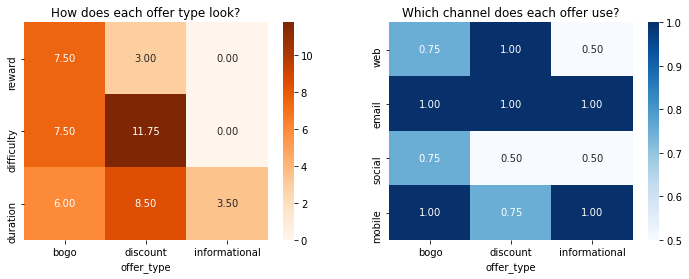

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

sns.heatmap(portfolio_v1.iloc[:, :5].groupby('offer_type').mean().T, 
            annot=True, fmt='.2f', cmap='Oranges', ax=ax1);
sns.heatmap(portfolio_v1.iloc[:, 3:].groupby('offer_type').mean().T, 
            annot=True, fmt='.2f', cmap='Blues', ax=ax2);

ax1.set(title ='How does each offer type look?');
ax2.set(title ='Which channel does each offer use?');

`discount` offer requires the highest minium spends to get but has the longest duration, assuming customers feel the influence longer that the others. Regardless of offer type, `email` is always used when communicating the offer. `bogo` offer uses the widest number of channels. 

The analysis will be more meaningful when offer type is explored together with customer profile and transction data, which will be done later after mering the dataset.

###  Demographics

In [8]:
profile_v1.shape[0] # total 14825 unique demographic data

14825

In [9]:
profile_v1.head()

,gender,age,id,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [10]:
# It looks that 'became_member_on' is still object... 
# Convert to datetime object
profile_v1['became_member_on'] = pd.to_datetime(profile_v1['became_member_on'])

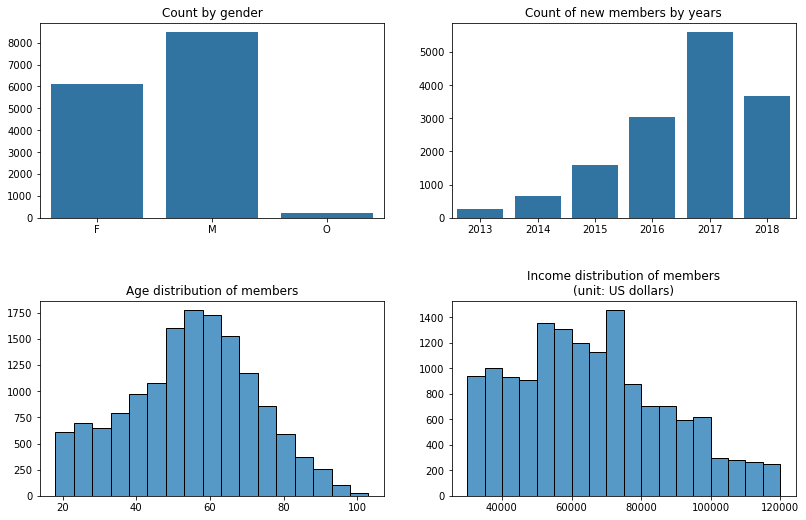

In [11]:
base_color = sns.color_palette()[0]

fig, axes = plt.subplots(2, 2, figsize=(12,8))

fig1 = sns.countplot(x=profile_v1.gender, ax=axes[0,0], color=base_color)
fig2 = sns.countplot(x=profile_v1.became_member_on.dt.year, ax=axes[0,1], color=base_color)
fig3 = sns.histplot(x=profile_v1.age, binwidth=5, ax=axes[1,0])
fig4 = sns.histplot(x=profile_v1.income, binwidth=5000, ax=axes[1,1])

fig1.set(title='Count by gender', xlabel='', ylabel='')
fig2.set(title='Count of new members by years', xlabel='', ylabel='')
fig3.set(title='Age distribution of members', xlabel='', ylabel='')
fig4.set(title='Income distribution of members\n(unit: US dollars)', xlabel='', ylabel='')

plt.tight_layout(pad=3.5)
plt.show()

In [12]:
# Percentage of male, female and others
profile_v1.gender.value_counts() / profile_v1.shape[0]

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

In [13]:
# Summary statistics for age
profile_v1.age.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [14]:
# Summary statistics for income
profile_v1.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

**Gender:** based on this dataset, male customers accounts for 57% of total, more than female (or others). 

**Date:** The growth of new members has increased over time, but it may need better comparison against other metrics like the total visitor volume to validate the organic growth. Also, the data collection period is not clear so 2013 and 2018 data may be biased. 

**Age:** The minimum age is 18 which may be due to age restriction for members. With the median of 55, 50% of the members fall interquartile range is between 42 and 66. There are some members above 100, which may be true or caused by survey error.

**Income:** Median income is $64,000. The distribution is skewed to the right which seems natural for income distribution.